In [1]:
import torch
import numpy as np
import ase.io
import tqdm

import sys
sys.path.append('../code/')
from code_pytorch import *
from utilities import *
from miscellaneous import ClebschGordan

from sklearn.linear_model import Ridge
from matplotlib import pyplot as plt

In [2]:
HARTREE_TO_EV = 27.211386245988
FORCE_FACTOR = 51.42208619083232
LAMBDA_MAX = 5
HYPERS = {
    'interaction_cutoff': 6.3,
    'max_radial': 5,
    'max_angular': LAMBDA_MAX,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.05,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'GTO'
    
}

train_subset = '0:10000'
test_subset = '10000:11000'
DEVICE = 'cuda'
METHANE_PATH = '../methane.extxyz'
N_SPARSE = 100
MAGIC_NUMBER = 10**5
clebsch = ClebschGordan(LAMBDA_MAX)


In [3]:
train_structures = ase.io.read(METHANE_PATH , index=train_subset)
test_structures = ase.io.read(METHANE_PATH , index=test_subset)

all_species = get_all_species(train_structures + test_structures)

train_coefficients = get_coefs(train_structures, HYPERS, all_species) 
test_coefficients = get_coefs(test_structures, HYPERS, all_species) 
for key in train_coefficients.keys():
    train_coefficients[key] *= MAGIC_NUMBER
for key in test_coefficients.keys():
    test_coefficients[key] *= MAGIC_NUMBER

train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV

mean_e = np.mean(train_energies)
train_energies = train_energies - mean_e
test_energies = test_energies - mean_e

#train_energies = torch.FloatTensor(train_energies).to(DEVICE)
#test_energies = torch.FloatTensor(test_energies).to(DEVICE)


In [4]:
block = ClebschCombining(clebsch.precomputed_, 0)
train_ps = block(train_coefficients, train_coefficients)[0].squeeze()
test_ps = block(test_coefficients, test_coefficients)[0].squeeze()

sparse_ind = np.random.permutation(train_ps.shape[0])[0:N_SPARSE]
sparse_points = train_ps[sparse_ind]
print(sparse_points.shape)


torch.Size([100, 600])


In [5]:
def get_kernel(features, sparse_points):
    return torch.matmul(features, torch.transpose(sparse_points, 0, 1)) ** 2

In [6]:
train_kernel = get_kernel(train_ps, sparse_points)
test_kernel = get_kernel(test_ps, sparse_points)
#print([0:5])
accumulator = Accumulator()
train_kernel = accumulator({"kernel": train_kernel}, train_structures)['kernel']
test_kernel = accumulator({"kernel": test_kernel}, test_structures)['kernel']
print(train_kernel.shape)
print(test_kernel.shape)
#print(train_kernel[0:5])
regr = Ridge(alpha = 1e-10, fit_intercept = False)
regr.fit(train_kernel.data.cpu().numpy(), train_energies)
predictions = regr.predict(test_kernel.data.cpu().numpy())

torch.Size([10000, 100])
torch.Size([1000, 100])


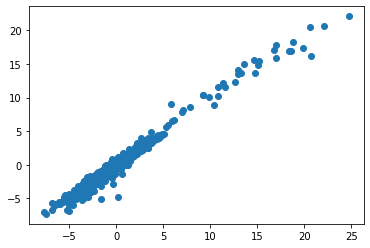

In [7]:
plt.plot(test_energies, predictions, 'o')
plt.show()

In [35]:
class KernelSingle(torch.nn.Module):
    def __init__(self, clebsch, sparse_points):
        super(KernelSingle, self).__init__()
        self.clebsch_combining = ClebschCombining(clebsch, 0)
        self.register_parameter('sparse_points', torch.nn.Parameter(sparse_points))
        self.linear = torch.nn.Linear(N_SPARSE, 1, bias = False)
        
    def forward(self, X):
        ps = self.clebsch_combining(X, X)[0].squeeze()
        kernel_values = get_kernel(ps, self.sparse_points)
        return {'energies' : self.linear(kernel_values)}
    

In [38]:
block = KernelSingle(clebsch.precomputed_, sparse_points)
with torch.no_grad():
    block.linear.weight = torch.nn.Parameter(torch.from_numpy(regr.coef_).type(torch.get_default_dtype()))
    
atomic_energies = block(train_coefficients)
for key in atomic_energies.keys():
    print(key, atomic_energies[key].shape)

energies torch.Size([50000])


energies torch.Size([1000])


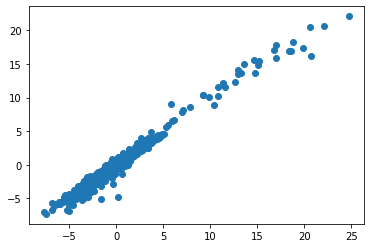

In [44]:
model = Atomistic(block)
test_predictions = model(test_coefficients, test_structures)
for key in test_predictions.keys():
    print(key, test_predictions[key].shape)
plt.plot(test_energies, test_predictions['energies'].data.cpu().numpy(), 'o')

In [46]:
torch.jit.trace(model, [test_coefficients, test_structures])

RuntimeError: Tracer cannot infer type of ({0: tensor([[[ 1.3944],
         [ 4.4301],
         [ 0.0984],
         ...,
         [ 1.7121],
         [-1.2746],
         [ 0.4686]],

        [[ 7.0542],
         [-3.7005],
         [ 2.7619],
         ...,
         [-0.1705],
         [ 0.1346],
         [-0.0421]],

        [[ 7.0893],
         [-4.0145],
         [ 2.4406],
         ...,
         [-0.1413],
         [ 0.1242],
         [-0.0392]],

        ...,

        [[ 7.2789],
         [-3.9648],
         [ 2.7422],
         ...,
         [ 0.6700],
         [-0.0717],
         [ 0.0365]],

        [[ 6.4689],
         [-5.3784],
         [ 3.1168],
         ...,
         [ 0.6840],
         [-0.0563],
         [ 0.0358]],

        [[ 7.2851],
         [-3.9933],
         [ 2.5409],
         ...,
         [ 0.3590],
         [-0.0448],
         [ 0.0133]]]), 1: tensor([[[ 1.4724e-01, -1.0742e+00, -7.5823e-01],
         [-5.2698e-01, -2.3928e+00, -1.2422e+00],
         [-7.8155e-01,  6.9463e-01,  5.9854e-01],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 1.0200e+00,  4.7845e-01, -4.0982e-02],
         [ 2.1179e+00,  7.4438e-01,  2.7864e-01],
         [-7.2643e-01,  4.6622e-01,  1.8737e+00],
         ...,
         [-8.8513e-02, -1.6510e-01, -2.2794e-01],
         [ 6.9890e-02,  1.3037e-01,  1.7998e-01],
         [-2.1840e-02, -4.0739e-02, -5.6242e-02]],

        [[-1.1113e+00, -4.2699e-01,  1.2164e-01],
         [-1.8274e+00, -9.1696e-01, -3.8999e-03],
         [-4.2551e-01,  8.1588e-02,  1.3265e+00],
         ...,
         [ 1.3831e-01, -4.5803e-02, -1.9643e-01],
         [-1.2155e-01,  4.0252e-02,  1.7262e-01],
         [ 3.8372e-02, -1.2707e-02, -5.4494e-02]],

        ...,

        [[-9.5544e-01,  1.0916e+00, -4.1455e-01],
         [-1.2556e+00,  1.4032e+00, -6.7295e-01],
         [ 1.2654e+00,  1.0141e+00,  7.8262e-01],
         ...,
         [ 1.0826e-01,  1.1484e+00,  1.2280e-01],
         [-1.1592e-02, -1.2297e-01, -1.3149e-02],
         [ 5.9013e-03,  6.2602e-02,  6.6941e-03]],

        [[-1.4711e-01, -8.2836e-04,  3.5036e-02],
         [ 3.5960e-01, -7.0418e-02, -1.1167e-01],
         [-2.1842e+00, -4.7344e-01,  3.4627e-01],
         ...,
         [-1.0124e+00,  5.7010e-01,  2.2981e-01],
         [ 8.3329e-02, -4.6923e-02, -1.8915e-02],
         [-5.3051e-02,  2.9873e-02,  1.2042e-02]],

        [[ 1.0497e+00, -1.0338e+00,  4.5361e-01],
         [ 1.1181e+00, -1.3625e+00,  7.6930e-01],
         [ 6.6879e-01,  9.9288e-01,  9.0583e-01],
         ...,
         [ 3.4294e-01,  4.7561e-01,  2.0608e-01],
         [-4.2803e-02, -5.9362e-02, -2.5722e-02],
         [ 1.2710e-02,  1.7627e-02,  7.6377e-03]]]), 2: tensor([[[-4.6147e-01,  2.5594e-01, -5.3380e-01,  3.8802e-01,  1.3775e+00],
         [-2.2178e+00, -2.8663e-01, -1.8062e+00,  9.9482e-01,  3.0202e+00],
         [-4.9065e-01, -7.7446e-01, -1.1500e-01,  1.4187e-01, -9.5894e-01],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[-1.6400e-01,  8.7088e-01, -3.8655e-01,  5.9084e-03, -1.0897e+00],
         [ 1.6112e-02,  1.8075e+00, -1.0849e+00, -2.3098e-01, -1.5490e+00],
         [-3.7720e-01, -9.7761e-01, -5.6639e-01,  9.3348e-01,  1.9036e+00],
         ...,
         [-1.5263e-01, -1.1056e-01,  1.1509e-02, -2.8470e-01, -1.6689e-01],
         [ 1.2052e-01,  8.7297e-02, -9.0878e-03,  2.2480e-01,  1.3178e-01],
         [-3.7661e-02, -2.7280e-02,  2.8399e-03, -7.0249e-02, -4.1179e-02]],

        [[-2.0010e-01,  8.7735e-01, -4.5052e-01, -3.4294e-02, -1.0696e+00],
         [-1.6729e-02,  1.8499e+00, -6.8171e-01, -1.9758e-01, -1.9617e+00],
         [-1.3000e+00, -4.0523e-01, -7.2658e-01, -2.6218e-01,  1.1560e+00],
         ...,
         [ 2.4797e-01,  5.7822e-02,  1.4101e-01, -8.2116e-02, -8.8775e-02],
         [-2.1792e-01, -5.0815e-02, -1.2392e-01,  7.2166e-02,  7.8018e-02],
         [ 6.8794e-02,  1.6041e-02,  3.9120e-02, -2.2781e-02, -2.4629e-02]],

        ...,

        [[ 6.3329e-01, -1.5020e+00,  4.6435e-01, -6.4124e-01, -5.5342e-01],
         [ 8.8737e-01, -1.9942e+00,  5.5666e-01, -1.0526e+00, -8.6893e-01],
         [-6.1143e-01,  1.3754e+00,  5.4205e-02,  1.3676e+00, -3.2870e-01],
         ...,
         [ 2.5610e-02,  2.3950e-01,  1.4519e+00,  2.7167e-01,  3.2368e-03],
         [-2.7422e-03, -2.5644e-02, -1.5547e-01, -2.9089e-02, -3.4658e-04],
         [ 1.3960e-03,  1.3055e-02,  7.9145e-02,  1.4809e-02,  1.7644e-04]],

        [[-5.8592e-02,  7.8237e-03, -8.7582e-02,  2.0490e-02, -1.2419e-01],
         [ 1.8304e-01,  1.1841e-01,  2.5715e-01, -8.6191e-02,  2.7829e-01],
         [-6.0165e-01,  9.9121e-01, -1.0291e+00,  7.1578e-02, -2.0125e+00],
         ...,
         [-4.3898e-01, -1.0890e+00, -2.3300e-01,  2.4719e-01, -9.1714e-01],
         [ 3.6131e-02,  8.9632e-02,  1.9177e-02, -2.0345e-02,  7.5487e-02],
         [-2.3003e-02, -5.7064e-02, -1.2209e-02,  1.2953e-02, -4.8059e-02]],

        [[ 6.5627e-01, -1.4966e+00,  3.9682e-01, -6.8814e-01, -6.3818e-01],
         [ 9.3702e-01, -2.0861e+00,  7.3313e-01, -7.7650e-01, -3.2508e-01],
         [ 3.3108e-01,  9.3980e-01, -9.0168e-01,  1.3239e+00,  2.7447e-01],
         ...,
         [ 2.5401e-01,  5.8622e-01,  3.0330e-01,  3.5228e-01, -1.3503e-01],
         [-3.1704e-02, -7.3168e-02, -3.7857e-02, -4.3969e-02,  1.6853e-02],
         [ 9.4140e-03,  2.1726e-02,  1.1241e-02,  1.3056e-02, -5.0043e-03]]]), 3: tensor([[[ 1.6099e-01, -7.3094e-02, -5.3260e-01,  ...,  4.3099e-01,
          -1.6819e+00,  4.8013e-01],
         [ 8.6233e-01, -8.4598e-01, -1.2921e+00,  ...,  1.2994e+00,
          -5.3794e+00,  5.0143e-01],
         [ 2.0896e-01, -6.2942e-01,  2.5186e-01,  ..., -1.4915e-01,
          -1.1179e-01, -8.8862e-01],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[-1.1111e+00, -1.8268e-01, -2.6239e-01,  ...,  6.5385e-02,
          -1.0747e+00,  1.3220e-01],
         [-1.7068e+00, -6.7386e-02, -4.7342e-01,  ..., -4.9445e-01,
          -2.1526e+00,  8.9383e-01],
         [ 2.1967e-01, -1.1081e+00, -3.8763e-01,  ..., -5.7683e-01,
           7.8836e-01,  1.0651e+00],
         ...,
         [-1.8095e-01, -2.2537e-01, -4.6632e-02,  ..., -1.2009e-01,
          -2.4642e-01, -8.9559e-02],
         [ 1.4288e-01,  1.7795e-01,  3.6822e-02,  ...,  9.4821e-02,
           1.9458e-01,  7.0718e-02],
         [-4.4649e-02, -5.5609e-02, -1.1506e-02,  ..., -2.9631e-02,
          -6.0804e-02, -2.2099e-02]],

        [[ 1.0052e+00,  7.5870e-02,  2.7396e-01,  ..., -4.9342e-02,
           1.0711e+00, -2.1629e-01],
         [ 2.0725e+00,  4.2344e-01,  4.0128e-01,  ...,  1.3746e-02,
           2.1256e+00, -1.0081e-01],
         [-1.7677e+00,  1.0631e-02,  3.7804e-01,  ..., -8.9134e-01,
          -1.0036e+00,  1.4098e-01],
         ...,
         [ 2.6865e-01,  1.2255e-01, -1.0623e-01,  ...,  1.5086e-01,
          -4.3873e-02,  7.4268e-02],
         [-2.3610e-01, -1.0770e-01,  9.3357e-02,  ..., -1.3258e-01,
           3.8558e-02, -6.5270e-02],
         [ 7.4532e-02,  3.3999e-02, -2.9471e-02,  ...,  4.1854e-02,
          -1.2172e-02,  2.0604e-02]],

        ...,

        [[ 1.5427e-01,  1.1685e+00, -1.3115e+00,  ..., -5.4130e-01,
          -1.0032e+00,  6.5066e-01],
         [ 2.0144e-01,  1.6459e+00, -1.7712e+00,  ..., -9.1499e-01,
          -1.5636e+00,  8.5869e-01],
         [-1.2278e+00, -1.0223e+00,  2.5187e-01,  ...,  1.4596e+00,
           1.4629e-01,  4.0373e-01],
         ...,
         [ 3.2514e-03,  6.7014e-02,  3.9435e-01,  ...,  4.4733e-01,
           8.4699e-03, -2.2092e-03],
         [-3.4814e-04, -7.1754e-03, -4.2224e-02,  ..., -4.7897e-02,
          -9.0690e-04,  2.3655e-04],
         [ 1.7723e-04,  3.6529e-03,  2.1496e-02,  ...,  2.4384e-02,
           4.6169e-04, -1.2043e-04]],

        [[ 8.5945e-02, -4.1351e-02,  9.9404e-02,  ..., -1.9041e-02,
           3.2501e-02, -5.5016e-02],
         [-1.4921e-01,  1.7837e-01, -3.3542e-01,  ...,  6.8642e-02,
           5.5451e-02,  1.6001e-01],
         [ 1.6806e+00, -1.1665e-01,  8.9806e-01,  ..., -1.3729e-01,
           1.3375e+00, -6.3765e-01],
         ...,
         [ 7.5409e-01, -5.5852e-01, -1.4980e-01,  ...,  3.4002e-02,
          -1.1669e+00, -5.9696e-01],
         [-6.2066e-02,  4.5970e-02,  1.2329e-02,  ..., -2.7986e-03,
           9.6043e-02,  4.9134e-02],
         [ 3.9515e-02, -2.9267e-02, -7.8493e-03,  ...,  1.7817e-03,
          -6.1146e-02, -3.1281e-02]],

        [[-2.7147e-01, -1.1847e+00,  1.2320e+00,  ...,  5.9397e-01,
           1.0094e+00, -6.4051e-01],
         [ 1.6114e-01, -1.5426e+00,  2.0222e+00,  ...,  8.4742e-01,
           1.6650e+00, -6.9417e-01],
         [-1.9563e-01,  1.0230e+00, -1.1185e+00,  ..., -1.4822e-01,
           5.9007e-01,  8.3697e-01],
         ...,
         [ 1.0484e-02,  5.1350e-01,  6.1691e-01,  ...,  3.7072e-01,
          -2.7297e-01, -1.9945e-01],
         [-1.3085e-03, -6.4093e-02, -7.7000e-02,  ..., -4.6272e-02,
           3.4070e-02,  2.4894e-02],
         [ 3.8855e-04,  1.9031e-02,  2.2864e-02,  ...,  1.3740e-02,
          -1.0117e-02, -7.3918e-03]]]), 4: tensor([[[-2.9509e-01,  6.9426e-01,  8.9485e-01,  ...,  8.7537e-01,
          -4.3637e-01, -2.8912e-01],
         [ 1.7440e-02,  2.1181e+00,  2.0963e+00,  ...,  2.2456e+00,
          -2.8056e+00, -7.8099e-01],
         [ 8.4094e-01,  8.8890e-02, -4.0238e-01,  ..., -3.6193e-01,
          -8.7028e-01,  1.8453e-02],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 1.8382e-01, -1.2947e+00, -5.0880e-02,  ..., -1.1818e-03,
           1.8146e-01,  9.6995e-01],
         [ 7.6554e-01, -2.1687e+00,  2.4737e-03,  ..., -5.8742e-01,
           4.0066e-01,  2.5467e+00],
         [ 2.3525e-01, -7.4345e-01, -1.1807e+00,  ..., -7.2069e-01,
          -4.0214e-01,  4.9100e-01],
         ...,
         [-1.7613e-01, -3.0268e-01, -1.5658e-01,  ..., -1.7120e-01,
          -1.4981e-01, -1.5751e-02],
         [ 1.3908e-01,  2.3901e-01,  1.2364e-01,  ...,  1.3519e-01,
           1.1829e-01,  1.2438e-02],
         [-4.3462e-02, -7.4688e-02, -3.8636e-02,  ..., -4.2245e-02,
          -3.6966e-02, -3.8866e-03]],

        [[ 2.1733e-01, -1.2320e+00,  2.0750e-02,  ..., -5.6728e-02,
           1.2784e-01,  9.7045e-01],
         [ 2.7577e-01, -2.2255e+00, -3.9177e-02,  ..., -1.0608e-01,
           5.8191e-01,  2.1354e+00],
         [-1.1899e+00,  9.9761e-01,  6.1261e-01,  ..., -5.0729e-01,
          -8.7778e-01, -7.3310e-01],
         ...,
         [ 1.8367e-01,  1.5041e-01, -1.6104e-01,  ...,  5.7653e-02,
           4.1582e-02,  2.2364e-01],
         [-1.6142e-01, -1.3219e-01,  1.4153e-01,  ..., -5.0669e-02,
          -3.6545e-02, -1.9655e-01],
         [ 5.0956e-02,  4.1731e-02, -4.4679e-02,  ...,  1.5995e-02,
           1.1537e-02,  6.2046e-02]],

        ...,

        [[-4.9022e-01,  3.3469e-01,  1.3192e+00,  ..., -1.1042e+00,
           1.3565e+00, -4.6702e-02],
         [-6.3648e-01,  4.6933e-01,  1.8739e+00,  ..., -1.7109e+00,
           1.7742e+00, -5.9158e-02],
         [ 3.6269e-01, -1.8762e+00, -1.0147e+00,  ...,  1.3459e+00,
           6.8622e-01,  1.1237e+00],
         ...,
         [ 1.4621e-04,  9.6441e-03,  1.2969e-01,  ...,  1.6391e-02,
          -6.5529e-03, -5.6916e-04],
         [-1.5655e-05, -1.0326e-03, -1.3886e-02,  ..., -1.7550e-03,
           7.0164e-04,  6.0942e-05],
         [ 7.9697e-06,  5.2570e-04,  7.0692e-03,  ...,  8.9347e-04,
          -3.5720e-04, -3.1025e-05]],

        [[ 2.2940e-02, -7.0731e-02,  1.9681e-02,  ...,  7.1129e-02,
          -4.5941e-02,  5.4162e-02],
         [-3.8117e-02,  6.7935e-02, -8.1509e-02,  ..., -2.8344e-01,
           2.1439e-01, -4.6480e-02],
         [ 4.4124e-01, -1.7092e+00,  7.3663e-02,  ...,  3.7619e-01,
          -2.7534e-02,  1.3758e+00],
         ...,
         [ 6.9557e-01,  1.0876e+00, -2.3588e-01,  ..., -4.9281e-01,
          -8.6096e-01,  5.6015e-01],
         [-5.7249e-02, -8.9514e-02,  1.9414e-02,  ...,  4.0561e-02,
           7.0862e-02, -4.6104e-02],
         [ 3.6448e-02,  5.6989e-02, -1.2360e-02,  ..., -2.5823e-02,
          -4.5115e-02,  2.9352e-02]],

        [[-5.0583e-01,  3.5927e-01,  1.3356e+00,  ..., -1.0826e+00,
           1.3163e+00,  2.5928e-02],
         [-4.8321e-01,  7.5317e-01,  1.9029e+00,  ..., -1.7472e+00,
           1.9949e+00, -3.2775e-01],
         [ 7.3165e-01,  5.3272e-01, -3.1917e-01,  ...,  1.5282e+00,
           5.5975e-01,  1.5149e+00],
         ...,
         [-1.1281e-01,  2.4019e-02,  6.7935e-01,  ..., -3.6113e-01,
          -4.5695e-01, -7.6126e-02],
         [ 1.4081e-02, -2.9980e-03, -8.4794e-02,  ...,  4.5074e-02,
           5.7034e-02,  9.5017e-03],
         [-4.1810e-03,  8.9021e-04,  2.5178e-02,  ..., -1.3384e-02,
          -1.6935e-02, -2.8214e-03]]]), 5: tensor([[[-5.9922e-01, -3.0068e-01, -1.5781e+00,  ...,  1.5281e-01,
          -3.6041e-01,  1.4202e+00],
         [-1.0708e+00,  9.7186e-01, -3.9556e+00,  ...,  2.5444e-01,
          -1.3184e+00,  4.7416e+00],
         [ 5.5472e-01,  1.1974e+00,  6.0433e-01,  ..., -3.7117e-01,
          -2.9140e-02,  2.2136e-01],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 9.4987e-01,  2.4041e-01, -3.6122e-01,  ...,  5.5952e-02,
           1.2599e+00, -3.2135e-01],
         [ 2.2245e+00,  6.2944e-01, -5.8864e-01,  ..., -3.1830e-01,
           2.5787e+00,  9.7077e-02],
         [ 4.9006e-01, -8.6703e-01, -1.4726e+00,  ..., -1.3835e+00,
          -1.3634e+00,  8.6124e-01],
         ...,
         [-1.4701e-01, -3.2543e-01, -2.7061e-01,  ..., -1.3394e-01,
          -2.9102e-02,  4.2465e-02],
         [ 1.1608e-01,  2.5697e-01,  2.1369e-01,  ...,  1.0576e-01,
           2.2980e-02, -3.3532e-02],
         [-3.6275e-02, -8.0302e-02, -6.6776e-02,  ..., -3.3050e-02,
          -7.1812e-03,  1.0479e-02]],

        [[-9.4555e-01, -2.1988e-01,  3.2020e-01,  ..., -5.7141e-02,
          -1.3710e+00,  2.4547e-01],
         [-2.0900e+00, -6.4883e-01,  5.8708e-01,  ..., -9.5241e-02,
          -2.2589e+00,  5.1741e-01],
         [-4.8781e-01,  1.3269e+00,  5.0176e-01,  ..., -2.6523e-01,
          -5.2879e-02, -6.1308e-01],
         ...,
         [ 2.1969e-02,  1.1359e-01, -1.5125e-01,  ..., -4.1812e-02,
           1.3831e-01,  2.9604e-01],
         [-1.9308e-02, -9.9831e-02,  1.3293e-01,  ...,  3.6748e-02,
          -1.2156e-01, -2.6018e-01],
         [ 6.0951e-03,  3.1515e-02, -4.1963e-02,  ..., -1.1601e-02,
           3.8373e-02,  8.2134e-02]],

        ...,

        [[ 2.1147e-01, -1.1372e+00,  4.6517e-01,  ...,  1.8109e+00,
          -1.2014e-01, -3.1203e-01],
         [ 3.3953e-01, -1.4836e+00,  7.0272e-01,  ...,  2.3389e+00,
          -1.8614e-01, -4.6074e-01],
         [ 5.8580e-01,  5.0914e-01, -1.4878e+00,  ...,  7.2092e-01,
           1.9047e+00, -1.8766e-01],
         ...,
         [-3.9411e-05,  4.7928e-04,  2.1023e-02,  ..., -1.4284e-02,
          -1.8658e-03, -7.7377e-05],
         [ 4.2199e-06, -5.1318e-05, -2.2509e-03,  ...,  1.5295e-03,
           1.9977e-04,  8.2850e-06],
         [-2.1483e-06,  2.6125e-05,  1.1459e-03,  ..., -7.7863e-04,
          -1.0170e-04, -4.2178e-06]],

        [[-4.5516e-02,  2.6027e-02, -5.0141e-02,  ...,  5.1165e-03,
          -1.0706e-01, -2.5774e-02],
         [ 2.7604e-02, -1.6309e-01,  2.4772e-01,  ..., -4.7512e-02,
           1.9382e-01,  1.4049e-01],
         [-1.2363e+00, -2.4638e-01,  2.9274e-02,  ..., -1.5108e-01,
          -2.0075e+00,  1.0291e-01],
         ...,
         [-3.6008e-01,  1.1087e+00,  6.7663e-01,  ..., -5.3564e-01,
           8.9286e-01,  7.3645e-01],
         [ 2.9637e-02, -9.1253e-02, -5.5690e-02,  ...,  4.4086e-02,
          -7.3487e-02, -6.0614e-02],
         [-1.8869e-02,  5.8097e-02,  3.5456e-02,  ..., -2.8068e-02,
           4.6786e-02,  3.8590e-02]],

        [[-9.8422e-02,  1.1285e+00, -4.3339e-01,  ..., -1.7428e+00,
           2.0162e-01,  3.3615e-01],
         [-4.7285e-01,  1.7641e+00, -8.4279e-01,  ..., -2.3460e+00,
           2.8021e-01,  3.9576e-01],
         [ 1.8400e+00,  7.1455e-01,  1.3953e+00,  ...,  1.3299e+00,
           1.0618e+00,  4.6595e-01],
         ...,
         [-8.3077e-02, -2.8559e-01,  3.6953e-02,  ..., -7.0300e-01,
          -1.9272e-01,  3.8713e-02],
         [ 1.0369e-02,  3.5647e-02, -4.6123e-03,  ...,  8.7746e-02,
           2.4055e-02, -4.8320e-03],
         [-3.0790e-03, -1.0585e-02,  1.3696e-03,  ..., -2.6055e-02,
          -7.1428e-03,  1.4348e-03]]])}, [Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...)), Atoms(symbols='CH4', pbc=False, forces=..., calculator=SinglePointCalculator(...))])
:Could not infer type of list element: Only tensors and (possibly nested) tuples of tensors, lists, or dictsare supported as inputs or outputs of traced functions, but instead got value of type Atoms.